# Import data_utils

In [1]:
from data_utils import *

2024-03-12 21:06:04.483512: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 21:06:04.486553: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 21:06:04.519459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 21:06:06.233346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Instantiate class

In [3]:
grid_path = '/work/sds-lab/Shuochen/climsim/normalizations_git/ClimSim_low-res_grid-info.nc'
norm_path = '/work/sds-lab/Shuochen/climsim/normalizations_git/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

# Load training and validation data

The .npy files shown below were created using the `create_npy_data_splits.ipynb` notebook in the preprocessing folder.

In [4]:
# Change this path to your own
data_path = '/work/sds-lab/Shuochen/climsim/'

train_input_path = data_path + 'train_input.npy'
train_target_path = data_path + 'train_target.npy'
val_input_path = data_path + 'val_input.npy'
val_target_path = data_path + 'val_target.npy'

data.input_train = data.load_npy_file(train_input_path)
data.target_train = data.load_npy_file(train_target_path)
data.input_val = data.load_npy_file(val_input_path)
data.target_val = data.load_npy_file(val_target_path)

# Train models

### Train constant prediction model

$\hat{y} = E[y_{train}]$

In [5]:
const_model = data.target_train.mean(axis = 0)

### Train multiple linear regression model

$\beta = {(X_{train}^TX_{train})}^{-1}X_{train}^Ty_{train}$

$\hat{y} = X_{input} \beta$

where $X_{train}$ and $X_{input}$ correspond to the training data and the input data you would like to inference on, respectively. $X_{train}$ and $X_{input}$ both have a column of ones concatenated to the feature space for the bias.


##### adding bias unit

In [6]:
X = data.input_train
bias_vector = np.ones((X.shape[0], 1))
X = np.concatenate((X, bias_vector), axis=1)

##### create model

In [7]:
mlr_weights = np.linalg.inv(X.transpose()@X)@X.transpose()@data.target_train

### Train your models here

In [8]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42

# use validation year
# X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
# y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

# X = torch.from_numpy(X).type(torch.float).to(device)
# y = torch.from_numpy(y).type(torch.float).to(device)

# X_train, X_test, y_train, y_test = train_test_split(X,
#     y,
#     test_size=0.2,
#     random_state=RANDOM_SEED
# )

# use all 8 years
X_train = torch.from_numpy(data.input_train).type(torch.float).to(device)
y_train = torch.from_numpy(data.target_train).type(torch.float).to(device)
X_test = torch.from_numpy(data.input_val).type(torch.float).to(device)
y_test = torch.from_numpy(data.target_val).type(torch.float).to(device)


class FCNN(nn.Module):
    def __init__(self, IN_FEATURES, hidden_dim, OUT_FEATURES):
        super().__init__()
        self.linear1 = nn.Linear(IN_FEATURES, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, OUT_FEATURES)
    def forward(self,x):
        return self.linear2(self.relu(self.linear1(x)))
        
model = FCNN(IN_FEATURES,32,OUT_FEATURES).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)

torch.manual_seed(42)
epochs = 400

for epoch in range(epochs):

    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

test_pred = torch.Tensor.cpu(test_pred).detach().numpy()
y_test = torch.Tensor.cpu(y_test).detach().numpy()

Using device: cuda
Epoch: 0 | Train loss: 0.05603673309087753 | Test loss: 0.04878628998994827
Epoch: 50 | Train loss: 0.006586418021470308 | Test loss: 0.006567607168108225
Epoch: 100 | Train loss: 0.005573159083724022 | Test loss: 0.005593819078058004
Epoch: 150 | Train loss: 0.005371259059756994 | Test loss: 0.005400619935244322
Epoch: 200 | Train loss: 0.005348830949515104 | Test loss: 0.005392055492848158
Epoch: 250 | Train loss: 0.005229455418884754 | Test loss: 0.0052603185176849365
Epoch: 300 | Train loss: 0.00519709475338459 | Test loss: 0.005272074602544308
Epoch: 350 | Train loss: 0.005151086952537298 | Test loss: 0.005185052752494812


In [9]:
data.input_train.shape

(10091520, 124)

# Evaluate on validation data

### Set pressure grid

In [10]:
data.set_pressure_grid(data_split = 'val')

### Load predictions

In [11]:
# Constant Prediction
const_pred_val = np.repeat(const_model[np.newaxis, :], data.target_val.shape[0], axis = 0)
print(const_pred_val.shape)

# Multiple Linear Regression
X_val = data.input_val
bias_vector_val = np.ones((X_val.shape[0], 1))
X_val = np.concatenate((X_val, bias_vector_val), axis=1)
mlr_pred_val = X_val@mlr_weights
print(mlr_pred_val.shape)

# Load your prediction here
fcnn_pred_val = test_pred
# Load predictions into data_utils object
data.model_names = ['const', 'mlr','FCNN'] # add names of your models here
preds = [const_pred_val, mlr_pred_val, fcnn_pred_val] # add your custom predictions here
data.preds_val = dict(zip(data.model_names, preds))

(1441920, 128)
(1441920, 128)


### Weight predictions and target

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [12]:
data.reweight_target(data_split = 'val')
data.reweight_preds(data_split = 'val')

### Set and calculate metrics

In [13]:
data.metrics_names = ['MAE', 'RMSE', 'R2', 'bias']
data.create_metrics_df(data_split = 'val')

/home/wang.shuoc/climsim/data_utils.py:1089: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/wang.shuoc/climsim/data_utils.py:1089: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/wang.shuoc/climsim/data_utils.py:1089: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/wang.shuoc/climsim/data_utils.py:1089: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/wang.shuoc/climsim/data_utils.py:1089: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time


### Create plots

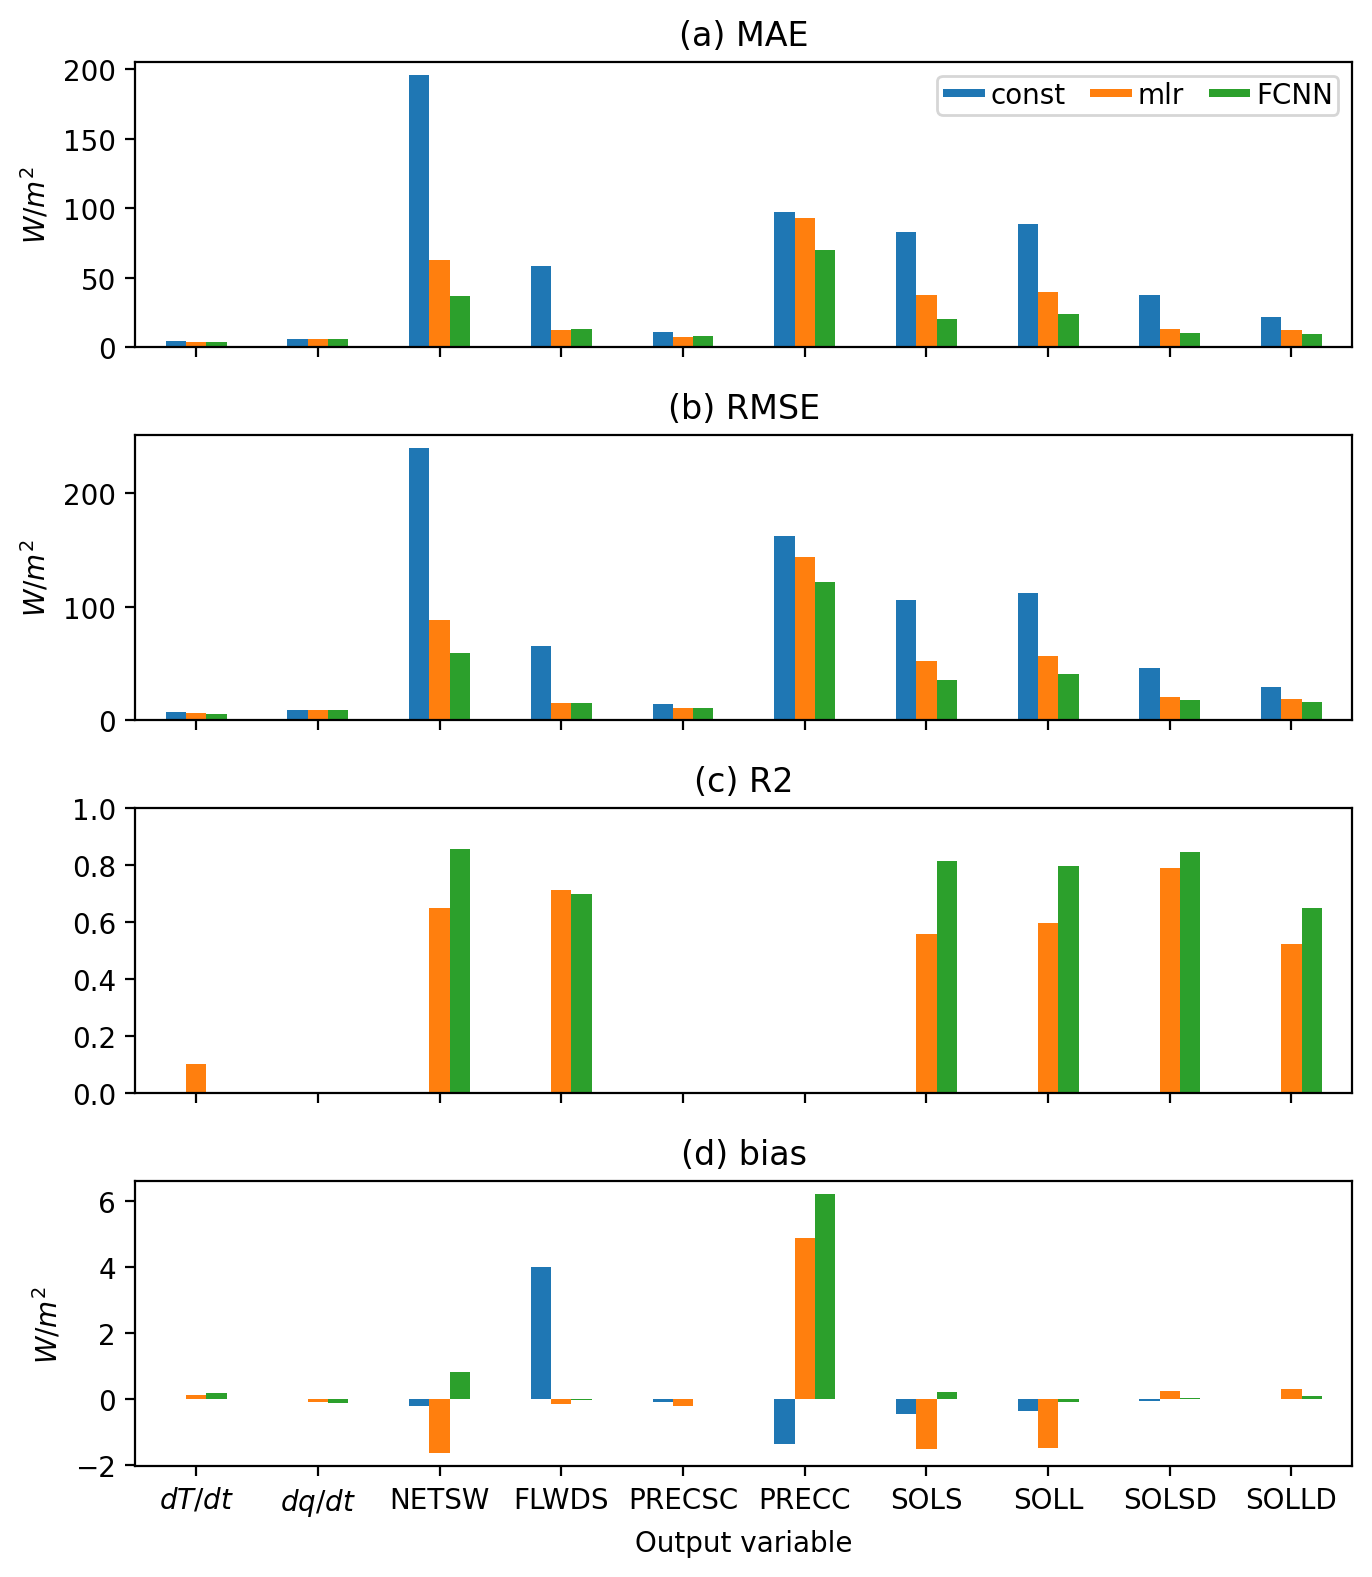

In [14]:
# set plotting settings
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

# create custom dictionary for plotting
dict_var = data.metrics_var_val
plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_var[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

# plot figure
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()

If you trained models with different hyperparameters, use the ones that performed the best on validation data for evaluation on scoring data.

## Evaluate on scoring data

#### Do this at the VERY END (when you have finished tuned the hyperparameters for your  model and are seeking a final evaluation)

### Load scoring data

In [15]:
scoring_input_path = "/work/sds-lab/Shuochen/climsim/scoring_input.npy"
scoring_target_path = "/work/sds-lab/Shuochen/climsim/scoring_target.npy"

# path to target input
data.input_scoring = np.load(scoring_input_path)

# path to target output
data.target_scoring = np.load(scoring_target_path)

### Set pressure grid

In [16]:
data.set_pressure_grid(data_split = 'scoring')

### Load predictions

In [17]:
# constant prediction
const_pred_scoring = np.repeat(const_model[np.newaxis, :], data.target_scoring.shape[0], axis = 0)
print(const_pred_scoring.shape)

# multiple linear regression
X_scoring = data.input_scoring
bias_vector_scoring = np.ones((X_scoring.shape[0], 1))
X_scoring = np.concatenate((X_scoring, bias_vector_scoring), axis=1)
mlr_pred_scoring = X_scoring@mlr_weights
print(mlr_pred_scoring.shape)

# Your model prediction here
fcnn_pred_val = test_pred
# Load predictions into object
data.model_names = ['const', 'mlr', 'FCNN'] # model name here
preds = [const_pred_scoring, mlr_pred_scoring, fcnn_pred_val] # add prediction here
data.preds_scoring = dict(zip(data.model_names, preds))

(1681920, 128)
(1681920, 128)


### Weight predictions and target

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [18]:
# weight predictions and target
data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

# set and calculate metrics
data.metrics_names = ['MAE', 'RMSE', 'R2', 'bias']
data.create_metrics_df(data_split = 'scoring')

ValueError: operands could not be broadcast together with shapes (3755,384,60) (4380,384,60) 

### Create plots

In [ ]:
# set plotting settings
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

# create custom dictionary for plotting
dict_var = data.metrics_var_scoring
plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_var[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

# plot figure
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()